##  Regressão por Processos Gaussianos (GPR)

A regressão por processos gaussianos (GPR) é um método não paramétrico para modelagem de funções e predição de valores desconhecidos, baseado em estatística bayesiana.

### Modelo do Processo Gaussiano

A suposição básica é que a função alvo pode ser modelada como:

$
y(\mathbf{x}) = f(\mathbf{x}) + \epsilon
$

onde:
- $ f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')) $ é um processo gaussiano com média $ m(\mathbf{x}) $ e função de covariância (kernel) $ k $.
- $ \epsilon \sim \mathcal{N}(0, \sigma_n^2) $ é o ruído gaussiano.

### Predição

Dado um conjunto de dados de treino $ \mathcal{D} = \{(\mathbf{X}, \mathbf{y})\} $, a predição para um novo ponto $ \mathbf{x}_* $ é feita usando as seguintes fórmulas:


#### Predição

$
\mu(\mathbf{x}_*) = \mathbf{k}_*^\top \mathbf{K}^{-1} \mathbf{y}
$

#### Variância predita

$
\sigma^2(\mathbf{x}_*) = k_{**} - \mathbf{k}_*^\top \mathbf{K}^{-1} \mathbf{k}_*
$

onde

- $ \mathbf{K} = k(\mathbf{X}, \mathbf{X}) + \sigma_n^2 \mathbf{I} $ — matriz de covariância dos dados de treino
- $ \mathbf{k}_* = k(\mathbf{X}, \mathbf{x}_*) $ — vetor de covariância entre os dados de treino e o novo ponto
- $ k_{**} = k(\mathbf{x}_*, \mathbf{x}_*) $ — variância do novo ponto


### Kernel (Função de Covariância)

O kernel define a similaridade entre pontos.

- **RBF (Gaussiano):**
  $
  k(\mathbf{x}, \mathbf{x}') = \sigma_f^2 \exp\left(-\frac{||\mathbf{x} - \mathbf{x}'||^2}{2l^2}\right)
  $
- **Matern, RationalQuadratic, ExpSineSquared, DotProduct, etc.**

### Resumindo...

A predição GPR retorna uma distribuição normal para cada ponto novo:

$
y_* \sim \mathcal{N}(\mu(\mathbf{x}_*), \sigma^2(\mathbf{x}_*))
$

onde a média e a variância são dadas pelas fórmulas acima.

---
**Referência:** Rasmussen & Williams, "Gaussian Processes for Machine Learning" (2006)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures


In [2]:

# Para ignorar os avisos de convergência do algroritmo de otimização que maximiza a função de verossimilhança.
# Os avisos são gerados pelo sklearn quando o valor se aproxima do valor mínimo ou máximo especificado do parâmetro. Comentar, quando necessário, para verificar se o modelo está sendo construído corretamente.
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


$f(x_1,x_2) = 1.3356 \cdot (1.5 \cdot (1 - x_1)) + e^{2x_1 - 1} \cdot \sin(3\pi (x_1 - 0.6)^2) + e^{3x_2 - 0.5} \cdot \sin(4\pi (x_2 - 0.9)^2)$

In [3]:
def f(x1, x2):
    termo1 = 1.3356 * (1.5 * (1 - x1))
    termo2 = np.exp(2 * x1 - 1) * np.sin(3 * np.pi * (x1 - 0.6) ** 2)
    termo3 = np.exp(3 * x2 - 0.5) * np.sin(4 * np.pi * (x2 - 0.9) ** 2)
    return termo1 + termo2 + termo3

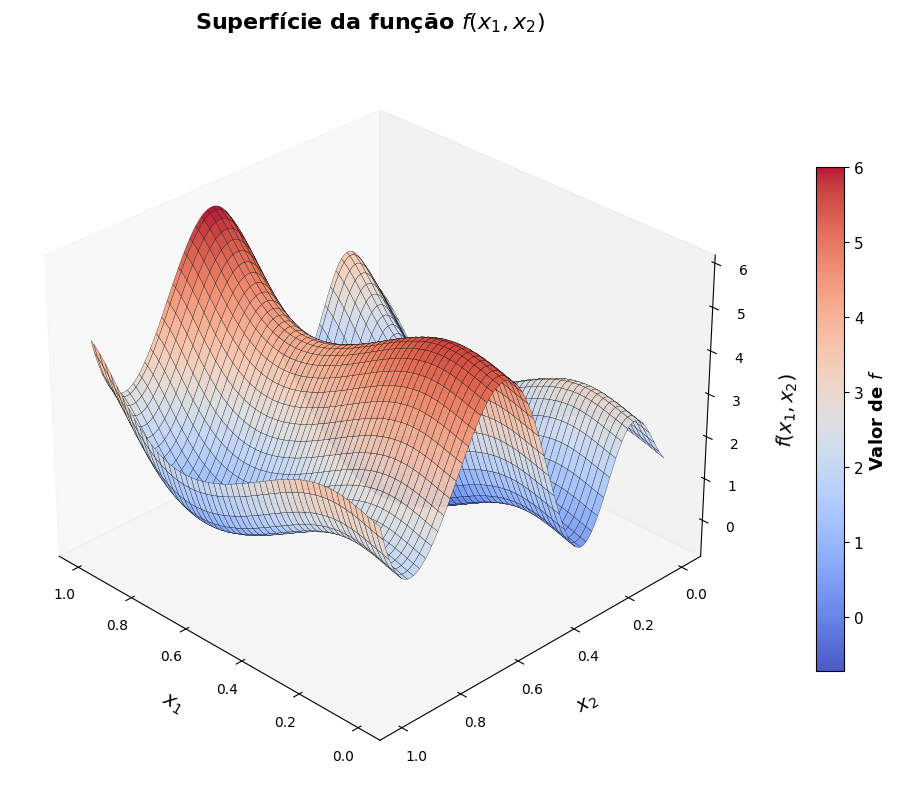

In [4]:
def plot_function(f, x1_range, x2_range, num_points=100, elev=30, azim=135, cmap='coolwarm'):
    x1 = np.linspace(*x1_range, num_points)
    x2 = np.linspace(*x2_range, num_points)
    X1, X2 = np.meshgrid(x1, x2)
    Z = f(X1, X2)

    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        X1, X2, Z, cmap=cmap, edgecolor='k', linewidth=0.2, alpha=0.92, antialiased=True
    )
    
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    ax.grid(False)

    ax.set_xlabel('$x_1$', fontsize=14, fontweight='bold', labelpad=12)
    ax.set_ylabel('$x_2$', fontsize=14, fontweight='bold', labelpad=12)
    ax.set_zlabel('$f(x_1, x_2)$', fontsize=14, fontweight='bold', labelpad=12)
    ax.set_title('Superfície da função $f(x_1, x_2)$', fontsize=16, fontweight='bold', pad=22)

    
    cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=18, pad=0.08)
    cbar.set_label('Valor de $f$', fontsize=13, fontweight='bold')
    cbar.ax.tick_params(labelsize=11)

    # Ajuste de visualização
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()

plot_function(f, x1_range=(0, 1), x2_range=(0, 1), cmap='coolwarm')

In [ ]:
def best_kernel_search(X, y, cv=5):
    # Testando diferentes kernels para encontrar o melhor kernel para o conjunto de dados de treinamento.

    kernels = [
        C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e+6)),
        C(1.0) * Matern(length_scale=1.0, nu=1.5, length_scale_bounds=(1e-6, 1e+6)),
        C(1.0) * RationalQuadratic(length_scale=1.0, alpha=0.1, length_scale_bounds=(1e-6, 1e+6)),
        C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(1e-6, 1e+6)),
        C(1.0) * DotProduct() + WhiteKernel()
    ]
    results = []
    for kernel in kernels:
        gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-8, normalize_y=True)
        gp.fit(X, y)
        scores = cross_val_score(gp, X, y, cv=cv, scoring='neg_mean_squared_error')
        mean_score = np.mean(scores)
        results.append((gp.kernel_, mean_score))
        print(f"Kernel: {gp.kernel_}\nMSE médio (negativo): {mean_score:.4f}\n")
        
    # Seleciona o kernel com maior score (maior valor)
    best_kernel, best_score = max(results, key=lambda x: x[1])
    print(f"Melhor kernel: {best_kernel}\nMSE médio (negativo): {best_score:.4f}")
    return best_kernel



In [6]:
X = np.random.uniform(0, 1, (50, 2))  # 50 pontos de treino
y = f(X[:, 0], X[:, 1])

# Encontra o melhor kernel usando validação cruzada para o conjunto de dados gerados. Desativa os avisos de convergência para evitar mensagens excessivas.
best_kernel = best_kernel_search(X, y)


Kernel: 1**2 * RBF(length_scale=1e-06)
MSE médio (negativo): -1.9384

Kernel: 1**2 * Matern(length_scale=1e-06, nu=1.5)
MSE médio (negativo): -1.9384

Kernel: 1.85**2 * RationalQuadratic(alpha=1e+05, length_scale=0.181)
MSE médio (negativo): -0.4886

Kernel: 1**2 * ExpSineSquared(length_scale=1e-06, periodicity=1e-05)
MSE médio (negativo): -1.9384

Kernel: 0.00316**2 * DotProduct(sigma_0=0.000146) + WhiteKernel(noise_level=1)
MSE médio (negativo): -1.9690

Melhor kernel: 1.85**2 * RationalQuadratic(alpha=1e+05, length_scale=0.181)
MSE médio (negativo): -0.4886


In [7]:
# Cria o regressor com o melhor kernel e ajusta aos dados
gp_best = GaussianProcessRegressor(kernel=best_kernel, alpha=1e-8, normalize_y=True)
gp_best.fit(X, y)

#Os hiperparâmetros do kernel são otimizados automaticamente durante o ajuste do modelo.
print(f"Melhor Kernel final com os hiperparâmetros otimizados:\n{gp_best.kernel_}")


Melhor Kernel final com os hiperparâmetros otimizados:
1.85**2 * RationalQuadratic(alpha=1e+05, length_scale=0.181)


In [8]:
def plot_predictions(gp, X_new, y_pred, sigma, x1_range=(0, 1), x2_range=(0, 1), num_points=100):
    x1 = np.linspace(*x1_range, num_points)
    x2 = np.linspace(*x2_range, num_points)
    X1, X2 = np.meshgrid(x1, x2)
    X_grid = np.column_stack([X1.ravel(), X2.ravel()])

    # Predição na grade
    y_grid_pred, _ = gp.predict(X_grid, return_std=True)
    Z = y_grid_pred.reshape(X1.shape)
    Z_true = f(X1, X2)  # Superfície verdadeira para comparação

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Superfície predita
    surf_pred = ax.plot_surface(
        X1, X2, Z, cmap='viridis', edgecolor='none', alpha=0.7, antialiased=True, zorder=2
    )
    # Superfície verdadeira
    surf_true = ax.plot_surface(
        X1, X2, Z_true, cmap='coolwarm', edgecolor='none', alpha=0.3, antialiased=True, zorder=1
    )

    # Pontos de predição
    ax.scatter(X_new[:, 0], X_new[:, 1], y_pred, color='red', s=70, label='Pontos de predição', zorder=3, edgecolor='k', linewidth=0.7)

    # Incerteza como barras de erro
    for i in range(len(X_new)):
        ax.plot([X_new[i, 0], X_new[i, 0]], [X_new[i, 1], X_new[i, 1]], [y_pred[i] - sigma[i], y_pred[i] + sigma[i]],
                color='black', linewidth=2, alpha=0.8)

    # Eixos e título
    ax.set_xlabel('$x_1$', fontsize=14, fontweight='bold', labelpad=12)
    ax.set_ylabel('$x_2$', fontsize=14, fontweight='bold', labelpad=12)
    ax.set_zlabel('$f(x_1, x_2)$', fontsize=14, fontweight='bold', labelpad=12)
    ax.set_title('Superfície predita (viridis) e verdadeira (coolwarm)', fontsize=15, fontweight='bold', pad=20)

    # Barras de cor
    m_pred = plt.cm.ScalarMappable(cmap='viridis')
    m_pred.set_array(Z)
    cbar_pred = fig.colorbar(m_pred, ax=ax, shrink=0.6, aspect=12, pad=0.08)
    cbar_pred.set_label('Predição', fontsize=12, fontweight='bold')
    cbar_pred.ax.tick_params(labelsize=11)

    m_true = plt.cm.ScalarMappable(cmap='coolwarm')
    m_true.set_array(Z_true)
    cbar_true = fig.colorbar(m_true, ax=ax, shrink=0.6, aspect=12, pad=0.16)
    cbar_true.set_label('Verdadeiro', fontsize=12, fontweight='bold')
    cbar_true.ax.tick_params(labelsize=11)

    ax.view_init(elev=30, azim=65)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    ax.grid(False)
    ax.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
    


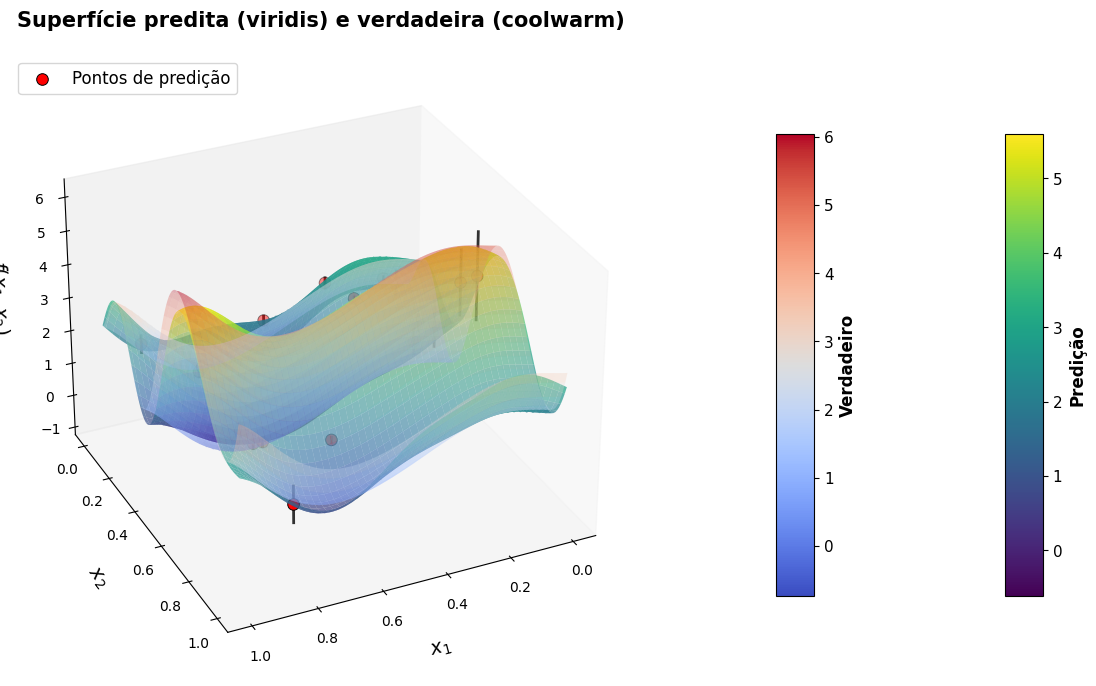

In [9]:
X_new = np.random.uniform(0, 1, (20, 2))  # 20 novos pontos para predição

# y_pred são as predições para os novos pontos
# sigma é o desvio padrão das predições, que representa a incerteza do modelo
y_pred, sigma = gp_best.predict(X_new, return_std=True)

plot_predictions(gp_best, X_new, y_pred, sigma=sigma, x1_range=(0, 1), x2_range=(0, 1), num_points=100)